In [1]:
%matplotlib widget
# %matplotlib inline
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# import os
import sys
sys.path.insert(0, '../02-scripts/functions/')
from metadata import get_rep, get_scan_number

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from Xana import Xana
from Xana import Soq
import pickle
from glob import glob
import pandas as pd
import pickle
import re
from lmfit.models import LinearModel
from tqdm import tqdm
import time
# from pathlib import Path
#plt.style.use('../nbstyle.mplstyle')

In [3]:
datadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/'
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'

In [4]:
# load elog as pd dataframe
elog = pd.read_pickle("../03-source/elog")

# Analysis database

In [5]:
datafolder = 'ferritin_conc_gly_50_5'
datasetnumber = 4 # 220 K 

**Elog info**

In [6]:
condition = elog['measurement folder'].str.contains(f'{datafolder}_{datasetnumber:04d}', na=False)
print("Temp: ", elog[condition]["Temperature, K"].values)
print("Transm: ", elog[condition]["transmission (%)"].values)

elog[condition]

Temp:  [220.]
Transm:  ['100']


,Sample,comment,Short comment,Sample no. (label),measurement folder,scan number,LN flow meter,"Temperature, K","Temperature, C",Exposure time (s),number of frames,Mesh (spots x lines),reps per spot,No of spots,Total exposure time (s),transmission (%),Absorbers 80um,Absorbers 100um,"position y, mm","position z, mm"
127,ferritin_conc_gly_50_5,"xpcs, 4 reps per spot, 220K, full beam",NaN,10.5,ferritin_conc_gly_50_5_0004,1-460,~1.9,220.0,NaN,0.0002,5000.0,16x7,NaN,112,1.0,100,0.0,0.0,"np.arange(-0.34, 0.6, 0.06)","np.arange(4.92 5.28, 0.06)"


In [7]:
ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p*/analysis_database.pkl')
ana_db_files

['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338204/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338206/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338208/analysis_database.pkl',
 '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338205/analysis_database.pkl']

In [8]:
d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl', maskfile='../setups/cryo-mask-230417_03.npy')

for i, f in enumerate(ana_db_files):
    if i == 0:
        d.load_db(f)
    else:
        d.append_db(f)
print("total entries in the database: ", len(d.db))

Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338204/analysis_database.pkl
Successfully loaded database
total entries in the database:  896


In [9]:
d.db['rep'] = d.db['master'].apply(lambda x: get_rep(x, reps_per_spot=4))
d.db['scannumber'] = d.db['datdir'].apply(lambda x: get_scan_number(str(x)))

In [10]:
d.db.head(10)

,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,rep,scannumber
0,True,,saxs,2023-06-19 17:54:58.615873,s0337_0000.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,337.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,337
1,True,,xpcs,2023-06-19 17:57:27.822539,s0337_0001.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,337.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,337
2,True,,saxs,2023-06-19 17:57:36.025666,s0338_0002.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,338.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,2,338
3,True,,xpcs,2023-06-19 18:00:05.406305,s0338_0003.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,338.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,2,338
4,True,,saxs,2023-06-19 18:00:13.590730,s0339_0004.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,339.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,3,339
5,True,,xpcs,2023-06-19 18:02:42.683619,s0339_0005.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,339.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,3,339
6,True,,saxs,2023-06-19 18:02:50.889518,s0340_0006.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,340.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,340
7,True,,xpcs,2023-06-19 18:05:19.788576,s0340_0007.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,340.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,340
8,True,,saxs,2023-06-19 18:05:28.028433,s0341_0008.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,341.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,341
9,True,,xpcs,2023-06-19 18:07:54.958657,s0341_0009.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,341.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,341


In [11]:
# ind_xpcs = d.db[(d.db['analysis'] == 'saxs')].index.values

rep = [1]
ind_saxs = d.db[(d.db['analysis'] == 'saxs')
               & (d.db['rep'].isin(rep))
                ].index.values
ind_xpcs = d.db[(d.db['analysis'] == 'xpcs')
                & (d.db['rep'].isin(rep))].index.values

print(f"number of saxs analysis: {len(ind_saxs)}")
print(f"number of xpcs analysis: {len(ind_xpcs)}")

# d.db.loc[ind_saxs]
# d.db.loc[ind_xpcs]

number of saxs analysis: 112
number of xpcs analysis: 112


In [12]:
# Check what happens in convert2hdf5
xpcs_indices = d.db[d.db['analysis'] == 'xpcs'].index.values[:]
print(len(xpcs_indices))
nxpcs = len(xpcs_indices)
tmp = d.get_item(xpcs_indices[0])
qv = tmp['qv']
nq = len(qv)
twotime_par = tmp['twotime_par']
nttc = len(twotime_par)
ttc_times = tmp['twotime_xy']
ntimes = len(ttc_times)

448


In [13]:
# %%time

# # Load all ttcs

# ttc_vs_q = np.empty(shape=(nxpcs,nttc))
# ttcs = np.zeros(shape=(nxpcs, nttc, ntimes, ntimes))

# # for i, xpcs_index in tqdm(enumerate(xpcs_indices), desc='writing XPCS results',  total=len(xpcs_indices)): # original with all repetitions
# for i, xpcs_index in tqdm(enumerate(xpcs_indices), desc='writing XPCS results',  total=len(xpcs_indices)): # only first repetition
#     tmp = d.get_item(xpcs_index)
#     ttcs[i] = np.stack(list(tmp['twotime_corf'].values()), axis=0)
#     ttc_vs_q[i,:] = ttcs[i].mean(axis=(1,2))
#     print(i, np.shape(ttcs[i]), np.shape(ttc_vs_q[i]))

# for convert2hdf5

**What to save**
- all g2s averaged per repetition per q: (nreps, nq)
- averaged ttc per repetition per q: (nreps, q, 4990, 4990)
- averaged ttc intensity per repetition per q: (nreps, nq) or (nspots*nreps, nq)


## from script function

In [3]:
def convert2hdf5(xana, filename):
    xana.db = xana.db.sort_values(by='scannumber')
    xpcs_indices = xana.db[xana.db['analysis'] == 'xpcs'].index.values
    nxpcs = len(xpcs_indices)
    xpcs_scans = xana.db.loc[xpcs_indices, 'scannumber'].values
    saxs_indices = xana.db[xana.db['analysis'] == 'saxs'].index.values
    nsaxs = len(saxs_indices)
    saxs_scans = xana.db.loc[saxs_indices, 'scannumber'].values

    qI = xana.get_item(saxs_indices[0])['soq'][:,0]
    nqI = len(qI)
    tmp = xana.get_item(xpcs_indices[0])
    ttc_times = tmp['twotime_xy']
    ntimes = len(ttc_times)
    delay = tmp['corf'][1:,0]
    ndelay = len(delay)
    qv = tmp['qv']
    nq = len(qv)
    twotime_par = tmp['twotime_par']
    nttc = len(twotime_par)

    path = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'
    print("\n\npath+filename", path+filename, "\n\n")

    # -- write metadata from elog
    # load elog as pd dataframe
    elog = pd.read_pickle("../03-source/elog")
    condition = elog['measurement folder'].str.contains(filename[:-3], na=False) # select the right entry
    elog_entries = elog[condition] # select elog entry
    print(elog_entries)
    print("\nTemp: ", elog_entries["Temperature, K"].values, "\n")    
    # -- end of elog writing prep
    
    
    print((f"{nqI = }, {nq = }, {ntimes = }, {nxpcs = }, {nsaxs = }, {ndelay = }, {nttc = }"))

    with h5py.File( path + filename, 'a') as f: # w for read/write/create access
        # write metadata
        for col in elog.columns:
            f[f'/elog/{col}'] = elog_entries[col].values[0]
        
        # write data
        # ttcs = f.create_dataset('/xpcs/ttcs/ttcs_all', shape=(nxpcs, nttc, ntimes, ntimes), dtype=np.float32, compression="gzip") # ideally I'll skip this
        ttcs_avg = f.create_dataset('/xpcs/ttcs/ttcs_avg', shape=(nttc, ntimes, ntimes), dtype=np.float32, compression="gzip") # averaged ttc
        ttcs_avg = f.create_dataset('/xpcs/ttcs/ttcs_avgI_q', shape=(nxpcs, nttc), dtype=np.float32, compression="gzip") # averaged ttc intens per spot per q    
        # ttcs_avg_f = f.create_dataset('/xpcs/ttcs/ttcs_f', shape=(nttc, ntimes, ntimes), dtype=np.float32, compression="gzip") # filtered averaged ttc
        g2s = f.create_dataset('/xpcs/g2s/g2s', shape=(nxpcs, nq, ndelay), dtype=np.float32, compression="gzip") # all g2s
        I = f.create_dataset('/saxs/I', shape=(nsaxs, nqI), dtype=np.float32, compression="gzip") # all Iqs
        f['/xpcs/g2s/delay'] = delay
        f['/xpcs/g2s/q'] = qv
        f['/xpcs/ttcs/q'] = qv[twotime_par]
        f['/xpcs/ttcs/times'] = ttc_times
        f['/xpcs/scans'] = xpcs_scans
        f['/saxs/q'] = qI
        f['/saxs/scans'] = saxs_scans
        
        for i, saxs_index in tqdm(enumerate(saxs_indices), desc='writing SAXS results',  total=len(saxs_indices)):
            tmp = xana.get_item(saxs_index)
            I[i] = tmp['soq'][:,1]
            # print(i, saxs_index)
            
######################################################
# -- params here
######################################################
# ferritin_conc_gly_50_6 5
datafolder = 'ferritin_conc_gly_50_6'
datasetnumber = 5

filename = f"{datafolder}_{datasetnumber:04}"
print(filename)

ana_db_files = glob(f'/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/{datafolder}_{datasetnumber:04}/p**/analysis_database.pkl', recursive=True)

xana = Xana()
for i, f in enumerate(ana_db_files):
    if i == 0:
        xana.load_db(f)
    else:
        xana.append_db(f)
        
xana.db['rep'] = xana.db['master'].apply(lambda x: get_rep(x, reps_per_spot=args.repsperspot))
xana.db['scannumber'] = xana.db['datdir'].apply(lambda x: get_scan_number(str(x)))
    
convert2hdf5(xana, filename + '.h5')

ferritin_conc_gly_50_6_0005
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_6_0005/p324129/analysis_database.pkl
Successfully loaded database


NameError: name 'get_rep' is not defined

## test here

In [14]:
datafolder = 'ferritin_conc_gly_50_5'
datasetnumber = 4
repsperspot = 4

filename = f"{datafolder}_{datasetnumber:04}" + '.h5'
print(filename)

ana_db_files = glob(f'/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/{datafolder}_{datasetnumber:04}/p**/analysis_database.pkl', recursive=True)

ferritin_conc_gly_50_5_0004.h5


In [15]:
# load xana db
xana = Xana()
for i, f in enumerate(ana_db_files):
    if i == 0:
        xana.load_db(f)
    else:
        xana.append_db(f)
        

xana.db['scannumber'] = xana.db['datdir'].apply(lambda x: get_scan_number(str(x)))
xana.db['rep'] = xana.db['master'].apply(lambda x: get_rep(x, reps_per_spot=repsperspot))    

Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc_gly_50_5_0004/p338204/analysis_database.pkl
Successfully loaded database


In [16]:
xana.db

,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,scannumber,rep
0,True,,saxs,2023-06-19 17:54:58.615873,s0337_0000.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,337.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,337,1
1,True,,xpcs,2023-06-19 17:57:27.822539,s0337_0001.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,337.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,337,1
2,True,,saxs,2023-06-19 17:57:36.025666,s0338_0002.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,338.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,338,2
3,True,,xpcs,2023-06-19 18:00:05.406305,s0338_0003.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,338.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,338,2
4,True,,saxs,2023-06-19 18:00:13.590730,s0339_0004.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,339.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,339,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,True,,xpcs,2023-06-19 21:35:16.342439,s0110_0219.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,110.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,110,2
892,True,,saxs,2023-06-19 21:35:22.655188,s0111_0220.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,111.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,111,3
893,True,,xpcs,2023-06-19 21:37:29.163697,s0111_0221.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,111.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,111,3
894,True,,saxs,2023-06-19 21:37:35.415464,s0112_0222.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,112.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,112,4


In [17]:
xana.db = xana.db.sort_values(by='scannumber')
xana.db
xpcs_indices = xana.db[xana.db['analysis'] == 'xpcs'].index.values
nxpcs = len(xpcs_indices)
xpcs_scans = xana.db.loc[xpcs_indices, 'scannumber'].values
saxs_indices = xana.db[xana.db['analysis'] == 'saxs'].index.values
nsaxs = len(saxs_indices)
saxs_scans = xana.db.loc[saxs_indices, 'scannumber'].values

In [18]:
qI = xana.get_item(saxs_indices[0])['soq'][:,0]
nqI = len(qI)
tmp = xana.get_item(xpcs_indices[0])
ttc_times = tmp['twotime_xy']
ntimes = len(ttc_times)
delay = tmp['corf'][1:,0]
ndelay = len(delay)
qv = tmp['qv']
nq = len(qv)
twotime_par = tmp['twotime_par']
nttc = len(twotime_par)

In [19]:
path = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'
print("\n\npath+filename", path+filename, "\n\n")



path+filename /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 




In [20]:
filename

'ferritin_conc_gly_50_5_0004.h5'

In [21]:
# -- write metadata from elog
# load elog as pd dataframe
elog = pd.read_pickle("../03-source/elog")
condition = elog['measurement folder'].str.contains(filename[:-3], na=False) # select the right entry
elog_entries = elog[condition] # select elog entry
print("\nTemp: ", elog_entries["Temperature, K"].values, "\n")    
# -- end of elog writing prep


Temp:  [220.] 



In [22]:
import h5py

**one loop per rep**

In [23]:
from Xana import CorrFunc

In [24]:
# repsperspot = 4
reps = np.arange(1,repsperspot+1)
reps

array([1, 2, 3, 4])

In [ ]:
# with h5py.File( path + filename + '_test_reps.h5', 'a') as f:
    # next step is to loop over the repetitions
# rep = 1
# ind_xpcs = xana.db[(xana.db['analysis'] == 'xpcs') & (xana.db['rep'].isin(rep))].index.values

#     ttcs = f.create_dataset('/xpcs/ttcs/ttcs_all', shape=(len(ind_xpcs, nttc, ntimes, ntimes), dtype=np.float32, compression="gzip"))
ttcs = np.empty(shape=(repsperspot, nttc, ntimes, ntimes))
g2s = np.empty(shape=(repsperspot, nq, ndelay))
ttcs_avg_int = np.empty(shape=4, dtype=object)
# baseline = np.empty(shape=(repsperspot,nttc))

for j,rep in enumerate(reps[:2]):
    # temporarily here, in the rep loop it will be overwritten
    ind_xpcs = xana.db[(xana.db['analysis'] == 'xpcs') & (xana.db['rep'] == rep)].index.values
    print("repetition: ", rep, '\t number of spots: ', len(ind_xpcs), '\n')
    ttc_int = np.empty(shape=(nxpcs, nttc))
    ttcs_qs = np.empty(shape=(len(ind_xpcs), nttc, ntimes, ntimes))
    g2s_qs = np.empty(shape=(len(ind_xpcs), nq, ndelay))
#     baseline = np.empty(shape=(len(ind_xpcs), nq, ndelay))
    # -- testing here
    baseline = []
    
    for i,ind in tqdm(enumerate(ind_xpcs), total=len(ind_xpcs)):
        ttcs_qs[i] = np.stack(list(xana.get_item(ind)['twotime_corf'].values()), axis=0)
        g2s_qs[i] = xana.get_item(ind)['corf'][1:,1:].T
        baseline.append(np.average(ttcs_qs[i][1])) # testing here
        
    g2s[j] = np.average(g2s_qs, axis=0)
    
    ttcs_avg_int[j] = ttcs_qs.mean(axis=(2,3))
    ttcs[j] = np.average(ttcs_qs, axis=0)

repetition:  1 	 number of spots:  112 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [05:26<00:00,  2.92s/it]


repetition:  2 	 number of spots:  112 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [05:12<00:00,  2.79s/it]


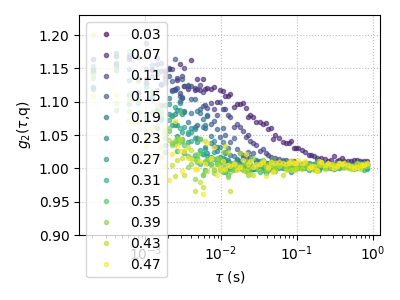

In [38]:
f,a1 = plt.subplots(1,1,figsize=(4,3))
col = plt.cm.viridis(np.linspace(0,1,nq))

for i,q in enumerate(qv):
    a1.plot(delay, g2s[0,i], marker='o', ms=3, ls='', alpha=.6, c=col[i], label=f'{q:.2f}')

a1.set_xscale('log')
a1.set_ylim(0.9, 1.23)
a1.set_xlabel(r'$\tau$ (s)')
a1.set_ylabel(r'$g_2(\tau$,q)')
a1.grid(ls=':', alpha=.5, c='gray')
a1.legend()
plt.tight_layout()
plt.show()

### the same for Iq

In [42]:
# for i, saxs_index in tqdm(enumerate(saxs_indices), desc='writing SAXS results',  total=len(saxs_indices)):
#     tmp = xana.get_item(saxs_index)
#     I[i] = tmp['soq'][:,1]
I_rep = np.empty(shape=(repsperspot, nqI))
for j,rep in enumerate(reps):
    # temporarily here, in the rep loop it will be overwritten
    ind_saxs = xana.db[(xana.db['analysis'] == 'saxs') & (xana.db['rep'] == rep)].index.values
    print("repetition: ", rep, '\t number of spots: ', len(ind_saxs), '\n')
    Is = np.empty(shape=(len(ind_saxs), nqI))

    for i,ind in tqdm(enumerate(ind_saxs), total=len(ind_saxs)):
        Is[i] = xana.get_item(ind)['soq'][:,1]
        
    I_rep[j] = np.average(Is, axis=0)


repetition:  1 	 number of spots:  80 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 186.85it/s]


repetition:  2 	 number of spots:  80 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 289.87it/s]


repetition:  3 	 number of spots:  80 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 186.96it/s]


repetition:  4 	 number of spots:  80 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 288.79it/s]


## Tesing filtering again

In [50]:
reps

array([1, 2, 3, 4])

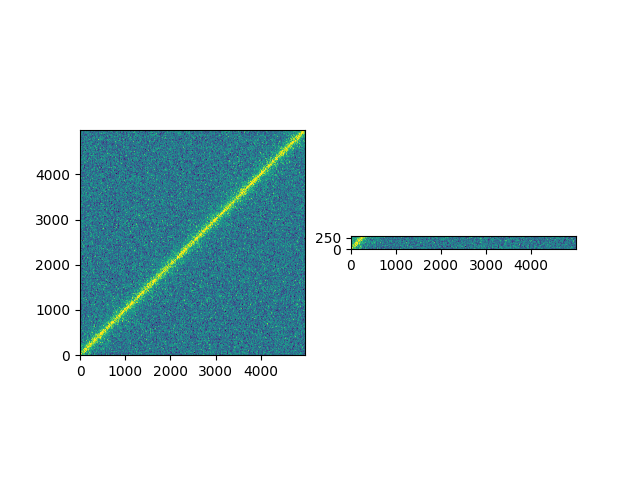

In [65]:
f,(a1,a2) = plt.subplots(1,2)
a1.imshow(ttcs[0,0], vmin=.9, vmax=1.1, origin='lower')
a2.imshow(ttcs[0,0][:300,:], vmin=.9, vmax=1.1, origin='lower')

In [25]:
ttcs = np.empty(shape=(repsperspot, nttc, ntimes, ntimes))
ttcs_avg_int = np.empty(shape=4, dtype=object)
baseline = np.empty(shape=4, dtype=object)
diag = np.empty(shape=4, dtype=object)

for j,rep in enumerate(reps[:1]):
    # temporarily here, in the rep loop it will be overwritten
    ind_xpcs = xana.db[(xana.db['analysis'] == 'xpcs') & (xana.db['rep'] == rep)].index.values
    print("repetition: ", rep, '\t number of spots: ', len(ind_xpcs), '\n')
    ttc_int = np.empty(shape=(nxpcs, nttc))
    ttcs_qs = np.empty(shape=(len(ind_xpcs), nttc, ntimes, ntimes))
    
    # -- testing here
    blist = np.empty(shape=len(ind_xpcs))
    dlist = np.empty(shape=len(ind_xpcs))
    
    for i,ind in tqdm(enumerate(ind_xpcs), total=len(ind_xpcs)):
        ttcs_qs[i] = np.stack(list(xana.get_item(ind)['twotime_corf'].values()), axis=0)
        
        blist[i] = np.average(ttcs_qs[i][1][:300,-300:]) # testing
        dlist[i] = np.average([np.mean(np.diag(ttcs_qs[i][1], k=j)) for j in [1,2,3,4,5]]) # testing

    ttcs_avg_int[j] = ttcs_qs.mean(axis=(2,3))
    ttcs[j] = np.average(ttcs_qs, axis=0)
    baseline[j] = blist
    diag[j] = dlist


repetition:  1 	 number of spots:  112 



100%|█████████████████████████████████████████████████████████████████████████████████████| 112/112 [04:51<00:00,  2.60s/it]


In [26]:
np.shape(baseline[0]), baseline[0][0]

((112,), 1.000798598807388)

Text(0.5, 1.0, 'diagonal: 97 good runs')

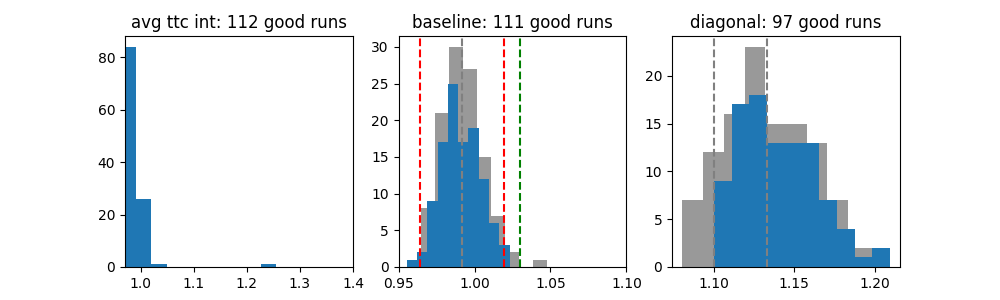

In [31]:
rep, q = 0, 0

f, (a1,a2,a3) = plt.subplots(1,3,figsize=(10,3))
# -- avg ttc intensity

distr = np.array(ttcs_avg_int[rep][:,q])
_, bins, _ = a1.hist(distr, color='gray', alpha=.8, bins=10)
# a1.axvline(x=np.mean(distr), c='gray', ls='--')
# a1.axvline(x=1.1, c='gray', ls='--')
ttcs_avg = np.mean(ttcs_avg_int[rep][:,q])
good_runs = (distr > ttcs_avg - .85*ttcs_avg)
_ = a1.hist(distr[good_runs])
a1.set_title(f"avg ttc int: {np.sum(good_runs)} good runs")
a1.set_xlim(.97,1.4)

# -- baseline
# plt.figure(figsize=(4,3))
sigma = 2
distr = np.array(baseline[rep])
_, bins, _ = a2.hist(distr, color='gray', alpha=.8, bins=10)
a2.axvline(x=np.mean(distr), c='gray', ls='--')
a2.axvline(x=np.mean(distr)+sigma*np.std(distr), c='r', ls='--')
a2.axvline(x=np.mean(distr)-sigma*np.std(distr), c='r', ls='--')
a2.axvline(x=1.03, c='g', ls='--')
# a2.axvline(x=1.1, c='gray', ls='--')
good_runs = (distr < 1.03)
_ = a2.hist(distr[good_runs])
a2.set_title(f"baseline: {np.sum(good_runs)} good runs")
a2.set_xlim(.95,1.1)

# -- diagonal
distr = np.array(diag[rep])
_, bins, _ = a3.hist(distr, color='gray', alpha=.8, bins=10)
a3.axvline(x=np.mean(distr), c='gray', ls='--')
a3.axvline(x=1.1, c='gray', ls='--')
good_runs = (distr > 1.1)
_ = plt.hist(distr[good_runs])
a3.set_title(f"diagonal: {np.sum(good_runs)} good runs")
# plt.xlim(.97,1)

In [33]:
f1 = 'ferritin_conc_gly_50_5_0004_filtered.h5'
f1[:-12]

'ferritin_conc_gly_50_5_0004'

In [39]:
print("\trepetition: ", rep, '\t number of spots: ', len(ind_xpcs))
print("\t\t\t good runs: ", np.sum(good_runs))

	repetition:  0 	 number of spots:  112
			 good runs:  97


# ===================
# ===================
# Filtering
# Iq vs ttc intensity

In [23]:
ttc_q_sel1 = 0
ttc_q_sel2 = 6

In [24]:
d.db = d.db.sort_values(by='scannumber')

# xpcs
xpcs_indices = d.db[d.db['analysis'] == 'xpcs'].index.values[:]
nxpcs = len(xpcs_indices)
xpcs_scans = d.db.loc[xpcs_indices, 'scannumber'].values[:]

tmp = d.get_item(xpcs_indices[0])
ttc_times = tmp['twotime_xy']
ntimes = len(ttc_times)
delay = tmp['corf'][1:,0]
ndelay = len(delay)
qv = tmp['qv']
nq = len(qv)
twotime_par = tmp['twotime_par']
nttc = len(twotime_par)


# saxs
saxs_indices = d.db[d.db['analysis'] == 'saxs'].index.values[:]
nsaxs = len(saxs_indices)
saxs_scans = d.db.loc[saxs_indices, 'scannumber'].values[:]

qI = d.get_item(saxs_indices[0])['soq'][:,0]
nqI = len(qI)


In [25]:
qv_ttcs = qv[twotime_par]
qv_ttcs

array([0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388,
       0.468])

In [26]:
qv[twotime_par[ttc_q_sel2]]

0.30800000000000005

**XPCS**

In [27]:
# %%time
# ttc_vs_q = np.empty(shape=(nxpcs,nttc))
# ttcs = np.zeros(shape=(nxpcs, nttc, ntimes, ntimes))

# for i, xpcs_index in tqdm(enumerate(xpcs_indices), desc='writing XPCS results',  total=len(ind_xpcs)):
#     tmp = d.get_item(xpcs_index)
#     ttcs[i] = np.stack(list(tmp['twotime_corf'].values()), axis=0)
#     ttc_vs_q[i,:] = ttcs[i].mean(axis=(1,2))
#     print(i, np.shape(ttcs[i]), np.shape(ttc_vs_q[i]))

In [28]:
%%time
# open twice, no saving
ttc_avg_q1 = np.zeros(shape=(nxpcs))
ttc_avg_q2 = np.zeros(shape=(nxpcs))

for i, xpcs_index in tqdm(enumerate(xpcs_indices), desc='writing XPCS results',  total=len(ind_xpcs)):
    # calculate the average of the whole ttc
    ttc_avg_q1[i] = np.average(d.get_item(xpcs_index)['twotime_corf'][twotime_par[ttc_q_sel1]])
    ttc_avg_q2[i] = np.average(d.get_item(xpcs_index)['twotime_corf'][twotime_par[ttc_q_sel2]])


writing XPCS results: 448it [14:46,  1.98s/it]                                  

CPU times: user 18.3 s, sys: 6min 40s, total: 6min 58s
Wall time: 14min 46s


In [19]:
# %%time
# # open once, save ttc
# ttc_avg_q1 = np.zeros(shape=(nxpcs))
# ttc_avg_q2 = np.zeros(shape=(nxpcs))

# for i, xpcs_index in tqdm(enumerate(xpcs_indices), desc='writing XPCS results',  total=len(xpcs_indices)):
#     # take one ttc
#     ttc = d.get_item(xpcs_index)['twotime_corf']
#     # calculate the average of the whole ttc
#     ttc_avg_q1[i] = np.average(ttc[twotime_par[ttc_q_sel1]])
#     ttc_avg_q2[i] = np.average(ttc[twotime_par[ttc_q_sel2]])

**SAXS**

In [23]:
%%time
I = np.zeros(shape=(nsaxs, nqI))

for i, saxs_index in tqdm(enumerate(saxs_indices), desc='writing SAXS results',  total=len(ind_saxs)):
    tmp = d.get_item(saxs_index)
    I[i] = tmp['soq'][:,1]

writing SAXS results: 320it [00:01, 318.58it/s]                                                                                                              

CPU times: user 365 ms, sys: 531 ms, total: 896 ms
Wall time: 1.01 s


In [27]:
Iq_scatter1 = []
Iq_scatter2 = []
q2 = qv[twotime_par[ttc_q_sel2]]
q1 = qv[twotime_par[ttc_q_sel1]]
dq = 0.01
for i,Iq in enumerate(I):
#     Iq_scatter1.append(Iq[125:127].mean())
    Iq_scatter1.append(Iq[(qI<q1+dq) & (Iq>q1-dq)].mean())
#     Iq_scatter2.append(Iq[-70:-20].mean())
    Iq_scatter2.append(Iq[(qI<q2+dq) & (Iq>q2-dq)].mean())

/tmp/ipykernel_13590/1819865659.py:10: RuntimeWarning: Mean of empty slice.
  Iq_scatter2.append(Iq[(qI<q2+dq) & (Iq>q2-dq)].mean())


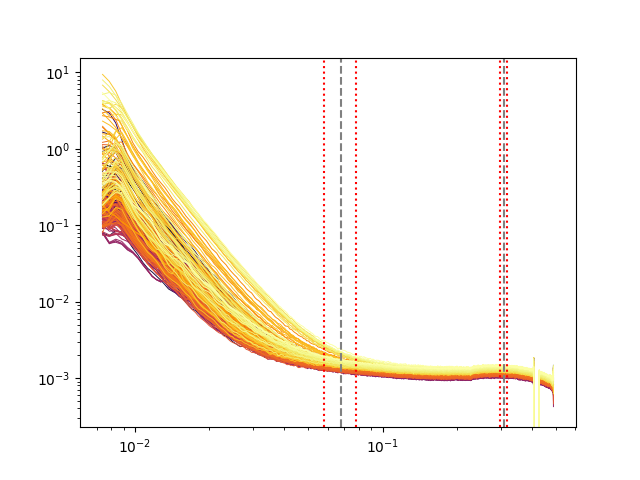

In [28]:
plt.figure()
# plt.plot(qI, I_avg)
col = plt.cm.inferno(np.linspace(0,1,nsaxs))

for i,Iq in enumerate(I):
    plt.plot(qI, Iq, lw=.7, c=col[i])
plt.axvline(x=qv_ttcs[ttc_q_sel1], c='gray', ls='--')
plt.axvline(x=qv_ttcs[ttc_q_sel2], c='gray', ls='--')

plt.axvline(x=q1-dq, c='r', ls=':')
plt.axvline(x=q1+dq, c='r', ls=':')
plt.axvline(x=q2+dq, c='r', ls=':')
plt.axvline(x=q2-dq, c='r', ls=':')

# plt.xlim(4e-1, 7e-1)
plt.xscale('log')
plt.yscale('log')

### scatter plot

In [30]:
from scipy.optimize import curve_fit

In [31]:
def linear(x,m,q):
    return m * x + q
         
def fit(function,x,y,p0=None,sigma=None,bounds=[None,None]):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    xc = np.linspace(min(x),max(x),len(x))
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

Text(0, 0.5, 'avg ttc1/nm')

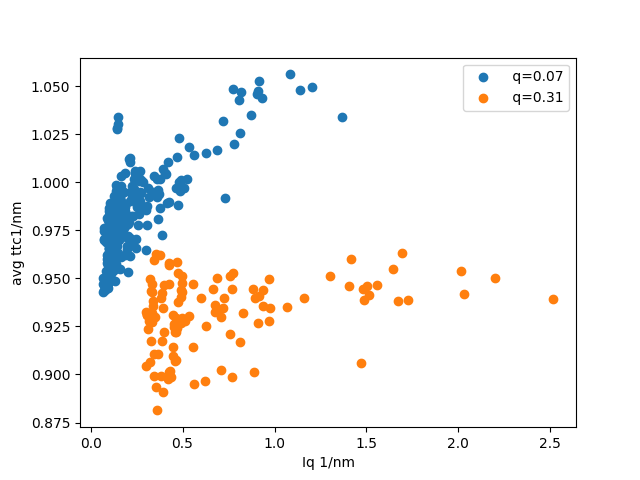

In [32]:
plt.figure()

plt.scatter(Iq_scatter1, ttc_avg_q1, label=f' q={qv_ttcs[ttc_q_sel1]:.2f}')
plt.scatter(Iq_scatter2, ttc_avg_q2, label=f' q={qv_ttcs[ttc_q_sel2]:.2f}')
# popt,xc,curve,perr = fit(gaussian, Iq_scatter, ttc_avg_q1, p0=[.4,.8,.3])

plt.legend()
plt.xlabel(f'Iq 1/nm')
plt.ylabel(f'avg ttc1/nm')
# plt.xlim(0,1)

# Average TTC int vs q

In [29]:
ttcs.shape

(10, 11, 4990, 4990)

Text(0, 0.5, 'ttc average intensity')

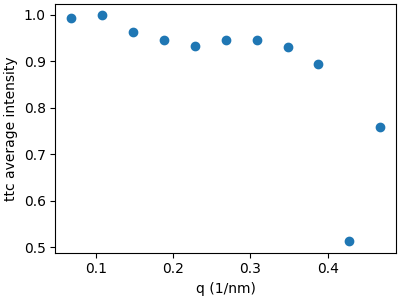

In [49]:
plt.figure(figsize=(4,3), constrained_layout=True)
for i in range(1,len(qv)):
#     x = np.average(ttcs[:,i,:,:])
    plt.plot(qv[i], np.average(ttcs[:,i-1,:,:]), ls='', marker='o', c='C0')
plt.xlabel('q (1/nm)')
plt.ylabel("ttc average intensity")

# Figure out how to filter

### Chech if g2s change with different filters

In [71]:
print("Number of saxs spots to average: ", len(ind_saxs))

Number of saxs spots to average:  80


### Compare trace to Iq at low q

**Trace**

In [72]:
tmp = d.get_item(ind_saxs[0])
keys_saxs = list(tmp.keys())
del tmp 

tmp = d.get_item(ind_xpcs[0])
keys_xpcs = list(tmp.keys())
del tmp
print("saxs: ", keys_saxs)
print("xpcs: ", keys_xpcs)

saxs:  ['Isaxs', 'Vsaxs', 'soq']
xpcs:  ['corf', 'dcorf', 'trace', 'qv', 'qroi', 'Isaxs', 'mask', 'twotime_corf', 'twotime_par', 'twotime_xy', 'chi4', 'xtwotime_corf', 'xchi4']


In [73]:
trace = d.get_item(ind_xpcs[0])['trace']
time = d.get_item(ind_xpcs[0])['twotime_xy']
qv = d.get_item(ind_xpcs[0])['qv']
print(np.shape(trace), np.shape(qv), np.shape(time))

(4990, 12) (12,) (4990,)


Text(0, 0.5, 'intensity')

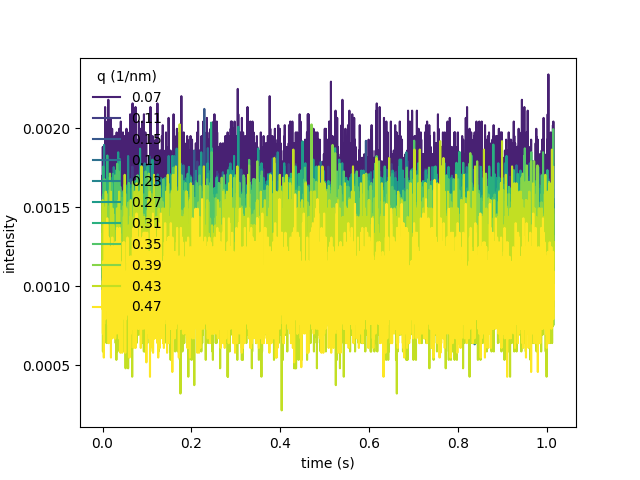

In [74]:
plt.figure()
c = plt.cm.viridis(np.linspace(0,1,len(qv)))
for i in range(1, len(qv)):
    plt.plot(time, trace[:,i], c=c[i], label=f'{qv[i]:.2f}')
plt.legend(frameon=False, title='q (1/nm)')
plt.xlabel('time (s)')
plt.ylabel('intensity')

**For all the indeces in the database**

In [50]:
%%time
q_annulus = -3
qv = d.get_item(ind_xpcs[0])['qv']
time = d.get_item(ind_xpcs[0])['twotime_xy']
traces = []

print(f"Trace being calculated for q={qv[q_annulus]:.2f} 1/nm")
for ind in tqdm(ind_xpcs):
    traces.append(d.get_item(ind)['trace'][:,q_annulus])

Trace being calculated for q=0.39 1/nm


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:13<00:00,  1.09it/s]

CPU times: user 1.06 s, sys: 42.4 s, total: 43.4 s
Wall time: 1min 14s


**TTC intensity**

In [51]:
ttc = d.get_item(ind_xpcs[0])['twotime_corf']
ttc_keys = list(ttc.keys())
print(type(ttc), np.shape(ttc_keys), qv[ttc_keys], np.shape(ttc[1]))

<class 'dict'> (11,) [0.068 0.108 0.148 0.188 0.228 0.268 0.308 0.348 0.388 0.428 0.468] (4990, 4990)


In [52]:
ind_xpcs[:10]

array([ 7, 15, 23, 31, 39, 47, 55, 63, 71, 79])

In [59]:
%%time
# q_annulus = 1
ttc_int = []
ttcs = []
print(f"TTC being calculated for q={qv[q_annulus]:.2f} 1/nm")
for ind in tqdm(ind_xpcs):
    ttcs.append(d.get_item(ind)['twotime_corf'][twotime_par[q_annulus]])
#     ttc_vs_q[i,:] = ttcs[i].mean(axis=(1,2))
    ttc_int.append(np.average(d.get_item(ind)['twotime_corf'][twotime_par[q_annulus]]))
print(np.shape(ttc_int))

TTC being calculated for q=0.39 1/nm


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:35<00:00,  2.28it/s]

(80,)
CPU times: user 2.36 s, sys: 32.6 s, total: 34.9 s
Wall time: 35 s


In [60]:
np.shape(ttcs), np.shape(ttc_int)

((80, 4990, 4990), (80,))

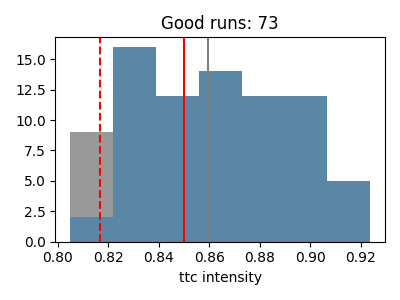

In [66]:
plt.figure(figsize=(4,3))

_, bins, _ = plt.hist(ttc_int, color='gray', alpha=.8, bins=7)
ttc_int = np.array(ttc_int)
ttcs_avg = np.mean(ttc_int)
# good_inds = ttc_int > ttcs_avg - 0.01*ttcs_avg
threshold1 = 0.05
threshold2 = 0.85
threshold3 = 1.2

cond1 = (ttc_int > ttcs_avg - threshold1*ttcs_avg) #& (ttc_int < ttcs_avg + threshold1*ttcs_avg)
# cond2 = ttc_int > threshold2
cond3 = ttc_int < threshold3

# good_inds = cond1 & cond2 & cond3
good_inds = cond1 & cond3
# ttc_int = np.array(ttc_int)

_ = plt.hist(ttc_int[good_inds], color='C0', alpha=0.5, bins=bins)

plt.axvline(x=ttcs_avg, c='gray', ls='-')
# plt.axvline(x=ttcs_avg + threshold1*ttcs_avg, c='r', ls='--')
plt.axvline(x=ttcs_avg - threshold1*ttcs_avg, c='r', ls='--')
plt.axvline(x=threshold2, c='r', ls='-')
# plt.axvline(x=threshold3, c='r', ls='-')

plt.title(f"Good runs: {len(ttc_int[good_inds])}")
plt.xlabel('ttc intensity')
plt.tight_layout();

### filtering with histo for all qs

In [67]:
 d.get_item(ind_xpcs[0]).keys()

dict_keys(['corf', 'dcorf', 'trace', 'qv', 'qroi', 'Isaxs', 'mask', 'twotime_corf', 'twotime_par', 'twotime_xy', 'chi4', 'xtwotime_corf', 'xchi4'])

In [68]:
qv = d.get_item(ind_xpcs[0])['qv']
twotime_par = d.get_item(ind_xpcs[0])['twotime_par']
time = d.get_item(ind_xpcs[0])['twotime_xy']
print(np.shape(qv), np.shape(twotime_par), np.shape(time))

(12,) (11,) (4990,)


In [82]:
%%time
# q_annulus = 1
ttc_int = np.empty(shape=(len(ind_xpcs), len(twotime_par)))
ttcs_qs = np.empty(shape=(len(ind_xpcs), len(twotime_par), len(time), len(time)))

print(f"TTC being calculated for q={qv[q_annulus]:.2f} 1/nm")

for i,ind in tqdm(enumerate(ind_xpcs), total=len(ind_xpcs)):
    ttcs_qs[i] = np.stack(list(d.get_item(ind)['twotime_corf'].values()), axis=0)
    ttc_int[i,:] = ttcs_qs[i].mean(axis=(1,2))

TTC being calculated for q=0.39 1/nm


80it [02:28,  1.86s/it]

CPU times: user 39.7 s, sys: 1min 49s, total: 2min 28s
Wall time: 2min 29s


In [83]:
np.shape(ttcs), np.shape(ttc_int)

((80, 11, 4990, 4990), (80, 11))

In [96]:
twotime_par

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

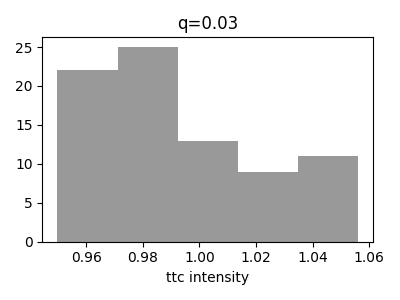

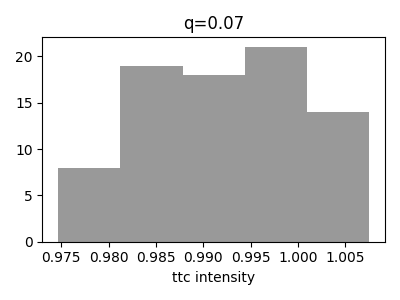

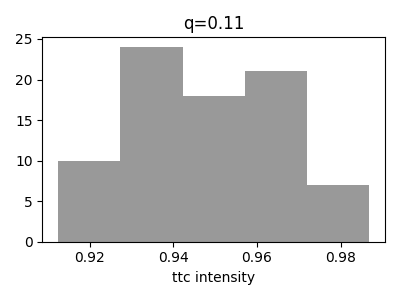

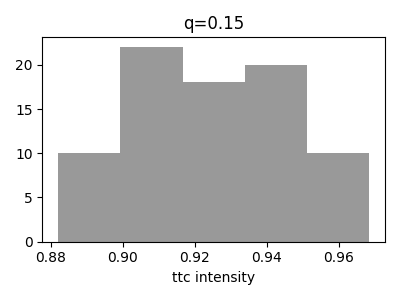

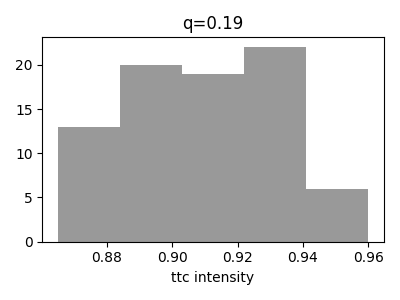

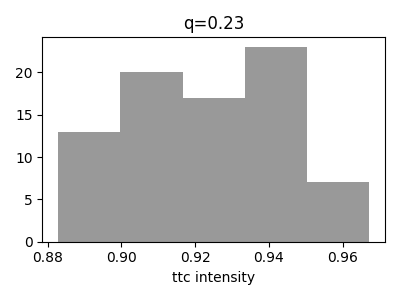

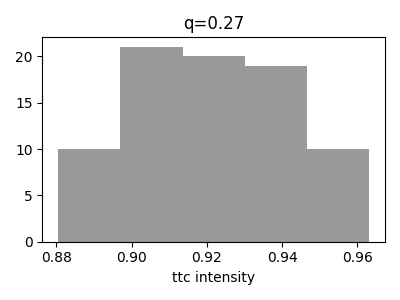

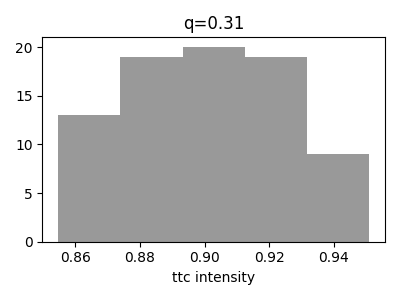

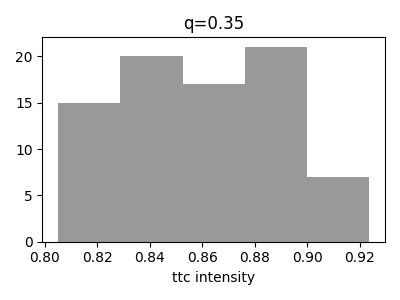

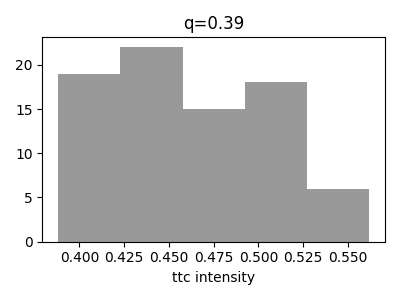

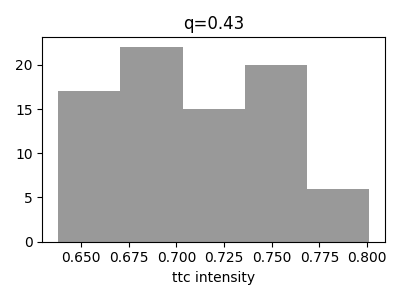

In [105]:
# good_inds = ttc_int > ttcs_avg - 0.01*ttcs_avg
threshold1 = 0.05
threshold2 = 0.85
threshold3 = 1.2

for q in range(len(twotime_par[:])):
    plt.figure(figsize=(4,3))
    ttc_distr = np.array(ttc_int[:,q])
    _, bins, _ = plt.hist(ttc_distr, color='gray', alpha=.8, bins=5)
    plt.title(f"q={qv[q]:.2f}")
    plt.xlabel('ttc intensity')
    plt.tight_layout();


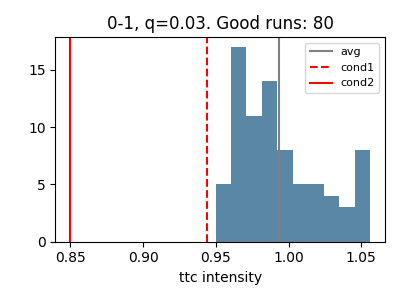

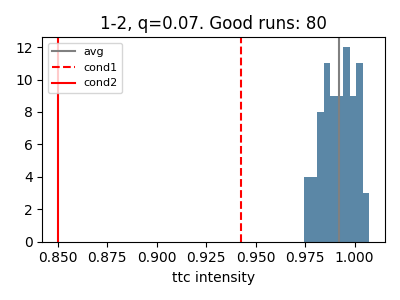

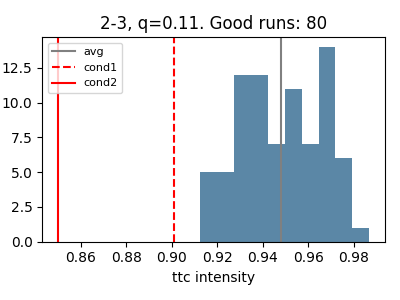

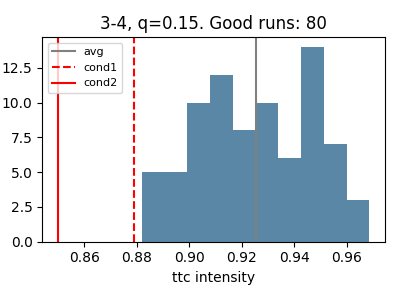

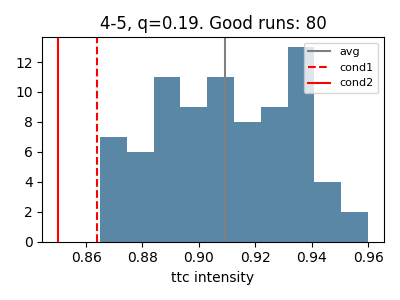

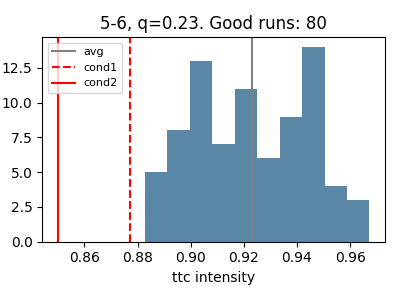

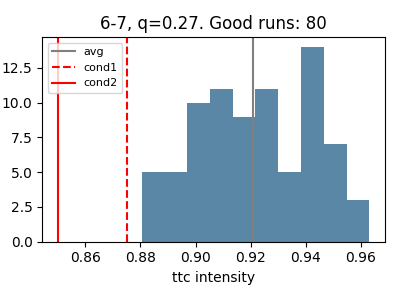

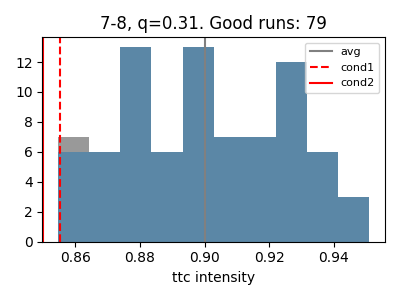

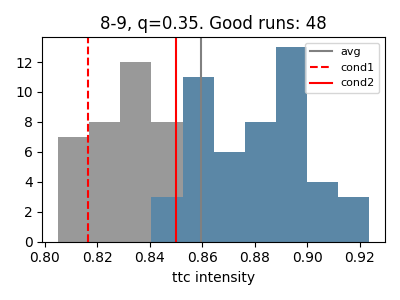

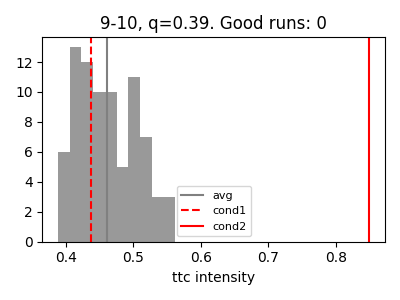

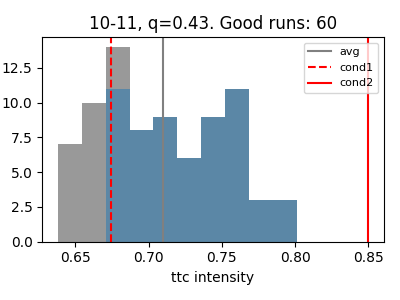

In [100]:
# good_inds = ttc_int > ttcs_avg - 0.01*ttcs_avg
threshold1 = 0.05
threshold2 = 0.85
threshold3 = 1.2

for q in range(len(twotime_par[:])):
    plt.figure(figsize=(4,3))
    ttc_distr = np.array(ttc_int[:,q])
    _, bins, _ = plt.hist(ttc_distr, color='gray', alpha=.8)
    ttcs_avg = np.mean(ttc_distr)
    
    cond1 = (ttc_distr > ttcs_avg - threshold1*ttcs_avg) #& (ttc_int < ttcs_avg + threshold1*ttcs_avg)
    cond2 = ttc_distr > threshold2
    cond3 = ttc_distr < threshold3

    if twotime_par[q] != 11:    
        good_inds = cond1 & cond2 & cond3
    else:
        good_inds = cond1 & cond3
    # ttc_int = np.array(ttc_int)

    _ = plt.hist(ttc_distr[good_inds], color='C0', alpha=0.5, bins=bins)

    plt.axvline(x=ttcs_avg, c='gray', ls='-', label='avg')
    # plt.axvline(x=ttcs_avg + threshold1*ttcs_avg, c='r', ls='--')
    plt.axvline(x=ttcs_avg - threshold1*ttcs_avg, c='r', ls='--', label='cond1')
    plt.axvline(x=threshold2, c='r', ls='-', label='cond2')
    # plt.axvline(x=threshold3, c='r', ls='-')

    plt.legend(fontsize=8)
    plt.title(f"{q}-{twotime_par[q]}, q={qv[q]:.2f}. Good runs: {len(ttc_distr[good_inds])}")
    plt.xlabel('ttc intensity')
    plt.tight_layout();


In [93]:
list(np.arange(1,len(d.setup.qroi)))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Now check Corr Func - plots

In [31]:
from Xana import CorrFunc

In [32]:
# initializing CorrFunc instance
g = CorrFunc(d)

# # searching data base for xpcs measurements
# ind = d.db[(d.db['analysis'] == 'xpcs')
#           &(d.db['use'] == True)].index.values

In [33]:
g.nq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [34]:
%%time
#loading correlation functions
g.get_g2(ind_xpcs, merge='merge')
# plotting
g.nq = np.arange(5)

Merged g2 functions:  [0.0002] (exposure times)
                      [80] (number of correlation functions)
                      [399200] (total number of images)
CPU times: user 1.11 s, sys: 31.7 s, total: 32.8 s
Wall time: 32.8 s


Fit successful: True
CPU times: user 682 ms, sys: 373 ms, total: 1.05 s
Wall time: 619 ms


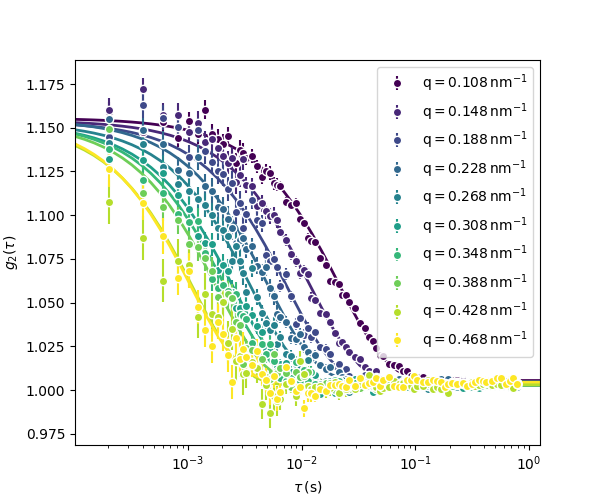

In [35]:
%%time
g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1,
          nq=np.arange(2,len(qv)),
        fix={'beta': 0.15, 'g0':1},
        init={'t0': (3e-3, 0, 1),
                'a': (.7, 0, 3),
                'g0': (1, 0, 2),
                #'beta': (.06, 0, 1)
            }, 
        #    fitglobal=['g0', 'a'], 
           cmap='viridis')

**Using good indices**

In [36]:
%%time
g2 = CorrFunc(d)

CPU times: user 43 µs, sys: 369 µs, total: 412 µs
Wall time: 391 µs


In [37]:
%%time
# good trains
ind_xpcs = np.array(ind_xpcs)
g2.get_g2(ind_xpcs[good_inds], merge='merge')

Merged g2 functions:  [0.0002] (exposure times)
                      [57] (number of correlation functions)
                      [284430] (total number of images)
CPU times: user 838 ms, sys: 22.5 s, total: 23.4 s
Wall time: 23.4 s


In [38]:
qv

array([0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348,
       0.388, 0.428, 0.468])

Fit successful: True
CPU times: user 564 ms, sys: 347 ms, total: 912 ms
Wall time: 501 ms


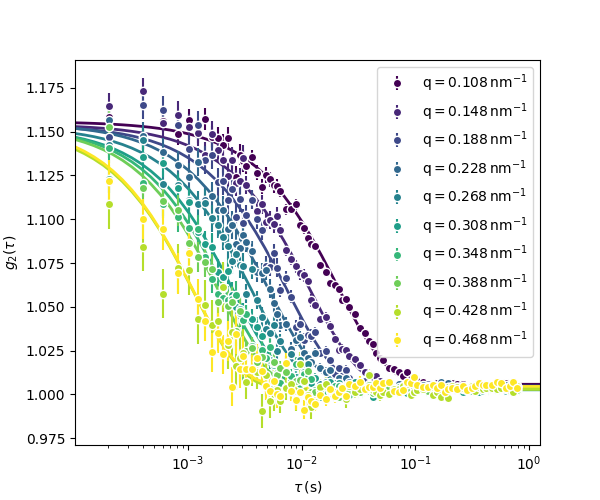

In [39]:
%%time
# plotting
g2.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1,
          nq=np.arange(2,len(qv)),
        fix={'beta': 0.15, 'g0':1},
        init={'t0': (3e-3, 0, 1),
                'a': (.7, 0, 3),
                'g0': (1, 0, 2),
                #'beta': (.06, 0, 1)
            }, 
        #    fitglobal=['g0', 'a'], 
           cmap='viridis')

In [30]:
g2.pars[0]

,q,t0,dt0,a,da,g0,dg0,b0,db0,beta,dbeta,chisqr,redchi,bic,aic
0,0.108,0.041074,0.000416,1.006190,0.000180,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
1,0.148,0.023755,0.000353,1.004006,0.000203,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
2,0.188,0.015229,0.000289,1.003766,0.000209,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
3,0.228,0.010356,0.000240,1.004769,0.000211,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
4,0.268,0.007465,0.000192,1.003078,0.000200,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
5,0.308,0.005380,0.000163,1.002543,0.000200,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
6,0.348,0.004447,0.000156,1.003457,0.000209,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
7,0.388,0.003747,0.000157,1.003321,0.000227,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
8,0.428,0.002374,0.000201,1.002689,0.000358,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326
9,0.468,0.002311,0.000162,1.004557,0.000289,1,0.0,0.15,0.0,0.15,0.0,772.274175,0.990095,105.474561,11.782326


In [31]:
g.pars[0].loc[9]
# df.loc[df['column_name'] == some_value]

q           0.468000
t0          0.002117
dt0         0.000123
a           1.004523
da          0.000229
g0          1.000000
dg0         0.000000
b0          0.150000
db0         0.000000
beta        0.150000
dbeta       0.000000
chisqr    786.267452
redchi      1.008035
bic       119.840455
aic        26.148221
Name: 9, dtype: float64

In [32]:
g2.pars[0].loc[9]

q           0.468000
t0          0.002311
dt0         0.000162
a           1.004557
da          0.000289
g0          1.000000
dg0         0.000000
b0          0.150000
db0         0.000000
beta        0.150000
dbeta       0.000000
chisqr    772.274175
redchi      0.990095
bic       105.474561
aic        11.782326
Name: 9, dtype: float64

### g2 from TTC

* `ttcs`
* `good_inds`
* `ind_xpcs`

In [40]:
ttcs = np.array(ttcs)

In [41]:
print(np.shape(ttcs), np.shape(ind_xpcs), np.shape(good_inds), np.shape(ttcs[good_inds,:,:]))

(80, 4990, 4990) (80,) (80,) (57, 4990, 4990)


In [42]:
ttcs_avg_qsel = np.mean(ttcs,axis=0)

In [43]:
time[-1]

1.0149621347954962

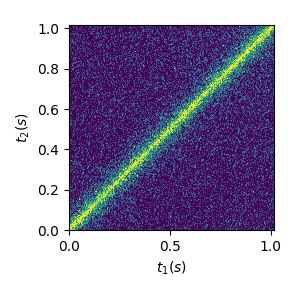

In [44]:
plt.figure(figsize=(3,3))
plt.imshow(ttcs_avg_qsel, vmin=0.98, vmax=1.1, origin='lower', extent=[time[0],time[-1]]*2)
plt.xlabel('$t_1 (s)$')
plt.ylabel('$t_2 (s)$')
plt.tight_layout()

In [45]:
g2_from_ttc = np.empty(ttcs.shape[-1])
for i in range(ttcs.shape[-1]):
    if i in [0,500,4000,4989]:
        print(i, np.shape(np.diag(ttcs_avg_qsel, k=i)))
    g2_from_ttc[i] = np.average(np.diag(ttcs_avg_qsel, k=i))
    
    
# filtered
ttcs_avg_qsel_f = np.mean(ttcs[good_inds],axis=0)
g2_from_ttc_f = np.empty(ttcs.shape[-1])
for i in range(ttcs.shape[-1]):
    if i in [0,500,4000,4989]:
        print(i, np.shape(np.diag(ttcs_avg_qsel_f, k=i)))
    g2_from_ttc_f[i] = np.average(np.diag(ttcs_avg_qsel_f, k=i))

0 (4990,)
500 (4490,)
4000 (990,)
4989 (1,)
0 (4990,)
500 (4490,)
4000 (990,)
4989 (1,)


In [46]:
g2s = g.corrFunc[0][0][1:,1:] # time, q
t_g2s = g.corrFunc[0][0][1:,0]
g2s_avg = g2s[:,1]

# filtered
g2s_f = g2.corrFunc[0][0][1:,1:] # time, q
t_g2s_f = g2.corrFunc[0][0][1:,0]
g2s_avg_f = g2s_f[:,1]

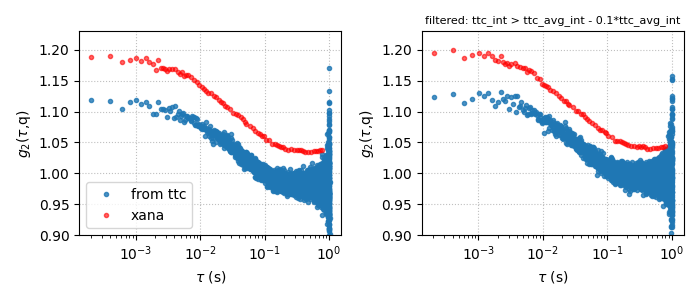

In [47]:
f,(a1,a2) = plt.subplots(1,2,figsize=(7,3))

a1.plot(time, g2_from_ttc, marker='o', ms=3, ls='', alpha=.8, label='from ttc')
a1.plot(t_g2s, g2s_avg, marker='o', ms=3, ls='', alpha=.6, c='r', label='xana')

# filtered
a2.plot(time, g2_from_ttc_f, marker='o', ms=3, ls='', alpha=.8, label='from ttc')
a2.plot(t_g2s_f, g2s_avg_f, marker='o', ms=3, ls='', alpha=.6, c='r', label='xana')

a1.set_xscale('log')
a1.set_ylim(0.9, 1.23)
a1.set_xlabel(r'$\tau$ (s)')
a1.set_ylabel(r'$g_2(\tau$,q)')
# plt.title(f'q={qv[q_annulus]:.3f} 1/nm')
a1.grid(ls=':', alpha=.5, c='gray')
a1.legend()
a2.set_xscale('log')
a2.set_ylim(0.9, 1.23)
a2.set_xlabel(r'$\tau$ (s)')
a2.set_ylabel(r'$g_2(\tau$,q)')
a2.grid(ls=':', alpha=.5, c='gray')
a2.set_title('filtered: ttc_int > ttc_avg_int - 0.1*ttc_avg_int', fontsize=8)
plt.tight_layout()
plt.show()

### For all qs

In [49]:
nxpcs = len(ind_xpcs)
tmp = d.get_item(ind_xpcs[0])
ttc_times = tmp['twotime_xy']
ntimes = len(ttc_times)
delay = tmp['corf'][1:,0]
ndelay = len(delay)
qv = tmp['qv']
nq = len(qv)
twotime_par = tmp['twotime_par']
nttc = len(twotime_par)

In [50]:
twotime_par

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [51]:
%%time
ttcs = np.empty(shape=(nxpcs, nttc, ntimes, ntimes))
ttc_int = np.empty(shape=nxpcs)

for i,ind in tqdm(enumerate(ind_xpcs)):
    tmp = d.get_item(ind)
    ttcs[i,:,:,:] = list(tmp['twotime_corf'].values())
    ttc_int[i] = np.average(ttcs[i,:,:,:])
    
print(np.shape(ttc_int), np.shape(ttcs))

80it [00:57,  1.39it/s]

(80,) (80, 11, 4990, 4990)
CPU times: user 18.3 s, sys: 39.5 s, total: 57.8 s
Wall time: 57.8 s


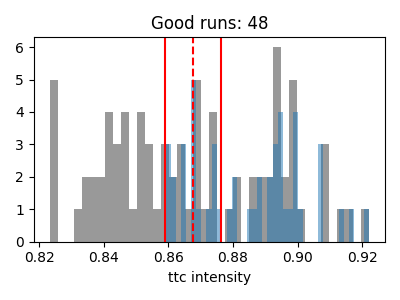

In [52]:
plt.figure(figsize=(4,3))

ttcs_avg = np.mean(ttc_int)
good_inds = ttc_int > ttcs_avg - 0.01*ttcs_avg

plt.hist(ttc_int, bins=40, color='gray', alpha=.8)
plt.hist(ttc_int[good_inds], bins=40, color='C0', alpha=0.5)

plt.title(f"Good runs: {len(ttc_int[good_inds])}")
plt.axvline(x=ttcs_avg, c='r', ls='--')
plt.axvline(x=ttcs_avg + 0.01*ttcs_avg, c='r', ls='-')
plt.axvline(x=ttcs_avg - 0.01*ttcs_avg, c='r', ls='-')
plt.xlabel('ttc intensity')
plt.tight_layout();

In [176]:
print(np.shape(ttcs))

(80, 11, 4990, 4990)


In [178]:
%%time
ttcs_avg = np.mean(ttcs,axis=0)
ttcs_avg_f = np.mean(ttcs[good_inds],axis=0)

print(np.shape(ttcs_avg), np.shape(ttcs_avg))

(11, 4990, 4990) (11, 4990, 4990)
CPU times: user 49.4 s, sys: 41.2 s, total: 1min 30s
Wall time: 1min 30s


## Based on Iq
**give up on this**

In [52]:
print("Number of saxs spots to average: ", len(ind_saxs))

Number of saxs spots to average:  80


In [53]:
tmp = d.get_item(ind_saxs[0])
keys = list(tmp.keys())

for key in keys:
    print(key, '\t', type(tmp[key]), np.shape(tmp[key]))

Isaxs 	 <class 'numpy.ndarray'> (514, 1030)
Vsaxs 	 <class 'numpy.ndarray'> (514, 1030)
soq 	 <class 'numpy.ndarray'> (1000, 3)


In [55]:
%%time
Iqs, dIqs = [], []
qs = d.get_item(ind_saxs[0])['soq'][:,0]

for ind in ind_saxs:
    Iqs.append(d.get_item(ind)['soq'][:,1])
    dIqs.append(d.get_item(ind)['soq'][:,2])
Iqs = np.array(Iqs)
dIqs = np.array(dIqs)
Iq_avg =  np.average(Iqs, axis=0)
dIq_avg =  np.std(Iqs, axis=0)
# Iq_avg_per_spot = np.average(Iqs, axis=1)
print(np.shape(Iqs), np.shape(dIqs), np.shape(Iq_avg), np.shape(dIq_avg))

(80, 1000) (80, 1000) (1000,) (1000,)
CPU times: user 731 ms, sys: 386 ms, total: 1.12 s
Wall time: 36.5 s


In [17]:
# q_sel = 0.1
# qind_sel = np.absolute(qs-q_sel).argmin()
# print(f"I wanted q={q_sel:.3f}. I found q={qs[qind_sel]:.3f} with index {qind_sel}")

I wanted q=0.040. I found q=0.040 with index 68


(0.0004, 0.01)

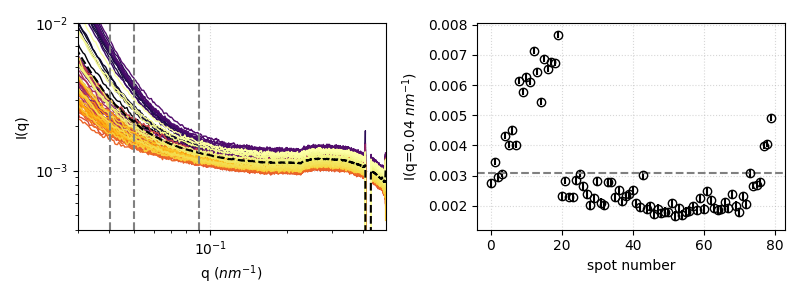

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
cols = plt.cm.inferno(np.linspace(0,1,len(Iqs)))

q_sel = 0.04
qind_sel = np.absolute(qs-q_sel).argmin()
print(f"I wanted q={q_sel:.3f}. I found q={qs[qind_sel]:.3f} with index {qind_sel}")

Iqs_at_q, dIqs_at_q = np.empty(Iqs.shape[0]), np.empty(Iqs.shape[0])
# print(np.shape(Iqs), np.shape(Iq_avg), np.shape(Iqs_at_q))

# ax3 = ax2.twinx()

for i,(Iq,dIq) in enumerate(zip(Iqs, dIqs)):
    ax1.plot(qs, Iq, lw=1, c=cols[i])
    # ax2.plot(i, Iq[q_sel], ls='', marker='o', c=cols[i], fillstyle='none')
    
    Iqs_at_q[i] = Iq[qind_sel]
    dIqs_at_q[i] = dIq[qind_sel]

    ax2.errorbar(i, Iqs_at_q[i], yerr=dIqs_at_q[i], ls='', marker='o', c='k', fillstyle='none')

# same_or_not = []
# for i in range(len(Iqs_at_q)-1):
#     same_or_not.append(Iqs_at_q[i] != Iqs[i,qind_sel])
# print("How many are different? ", np.sum(same_or_not))

ax1.plot(qs, Iq_avg, '--k')
ax1.axvline(x=qs[qind_sel], ls='--', c='gray')
ax1.axvline(x=5e-2, ls='--', c='gray')
ax1.axvline(x=9e-2, ls='--', c='gray')
ax2.axhline(y=np.mean(Iqs_at_q), ls='--', c='gray')

# ax3.yaxis.label.set_color('r')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('q ($nm^{{-1}}$)')
ax1.set_ylabel(f'I(q)')
ax2.set_ylabel(f'I(q={qs[qind_sel]:.2f} $nm^{{-1}}$)')
# ax3.set_ylabel(f'std I(q<={qs[qind_sel]:.2f} $nm^{{-1}}$)')
ax2.set_xlabel('spot number')
ax1.grid(ls=':', alpha=.5)
ax2.grid(ls=':', alpha=.5)
ax1.set_xlim(.03,qs[-1])
ax1.set_ylim(4e-4,1e-2)

In [59]:
import seaborn as sns

In [60]:
# dd = {'Iq': Iqs_at_q, 'dIq': dIqs_at_q}
df = pd.DataFrame({'Iq': Iqs_at_q, 'dIq': dIqs_at_q})
df.describe()

,Iq,dIq
count,80.000000,80.000000
mean,0.003085,0.000126
std,0.001606,0.000015
min,0.001673,0.000099
25%,0.001992,0.000117
50%,0.002376,0.000128
75%,0.003170,0.000139
max,0.007656,0.000149


In [ ]:
plt.figure(figsize=(4,3))
sns.histplot(data=df['Iq'])
plt.axvline(x=df['Iq'].mean(), ls='--', c='r')

val1, val2 = 0.3, 1.1
cond1 = df['Iq'].mean() < 0.2*df['Iq'].mean()
cond2 = df['Iq'].mean() > 0.3*df['Iq'].mean()
cond3 = (df['Iq'].mean() > val1*df['Iq'].mean()) and (df['Iq'].mean() < val2*df['Iq'].mean())

sns.histplot(data=df[cond1], x='Iq')

plt.axvline(x=cond1, ls='--', c='k')
plt.axvline(x=cond2, ls='--', c='k')

plt.axvline(x=df['Iq'].mean() - val1*df['Iq'].mean(), ls='--', c='b')
plt.axvline(x=df['Iq'].mean() + val2*df['Iq'].mean(), ls='--', c='b')

# plt.axvline(x=df['Iq'].mean() + 0.1*df['Iq'].mean(), ls='--', c='k')
plt.tight_layout()

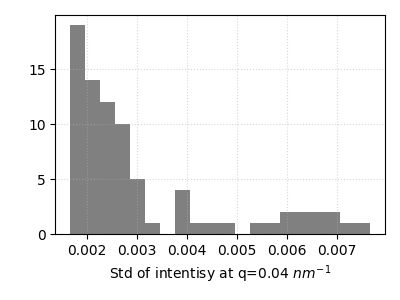

In [62]:
plt.figure(figsize=(4,3))

plt.hist(Iqs_at_q, bins=20, color='gray')

# good_ones = Iqs[dIqs_at_q < cond]
plt.grid(ls=':', alpha=.5) 
plt.xlabel(f'Std of intentisy at q={qs[qind_sel]:.2f} $nm^{{-1}}$')
plt.tight_layout()
plt.show()

/tmp/ipykernel_27968/1543917781.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)


NameError: name 'good_ones' is not defined

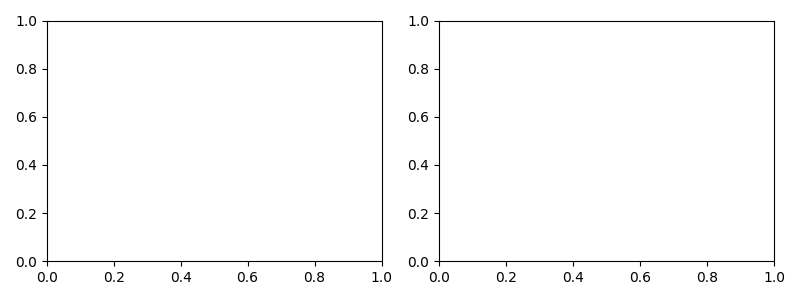

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
cols = plt.cm.inferno(np.linspace(0,1,len(Iqs)))
q_sel = 3
print(len(good_ones))
for i,Iq in enumerate(good_ones):
    ax1.plot(qs, Iq, lw=1, c=cols[i])
    # ax2.plot(i, Iq[q_sel], ls='', marker='o', c=cols[i], fillstyle='none')
    ax2.plot(i, Iq[q_sel], ls='', marker='o', c=cols[i],fillstyle='none')
ax1.plot(qs, Iq_avg, '--k')
ax1.axvline(x=qs[q_sel], ls='--', c='gray')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('q ($nm^{{-1}}$)')
ax1.set_ylabel(f'I(q)')
ax2.set_ylabel(f'I(q<={qs[q_sel]:.2f} $nm^{{-1}}$)')
ax2.set_xlabel('spot number')
ax1.grid(ls=':', alpha=.5)
ax2.grid(ls=':', alpha=.5)

**Based on TTC**

In [ ]:
tmp = d.get_item(ind_xpcs[0])
keys = list(tmp.keys())

for key in keys:
    # if not isinstance(tmp[key], (type(np.ndarray), type(np.array))):
    #     print('not np', key, '\t', type(tmp[key]), np.asarray(tmp[key]).shape)
    # else:
    print(key, '\t', type(tmp[key]), np.shape(tmp[key]))

corf 	 <class 'numpy.ndarray'> (81, 13)
dcorf 	 <class 'numpy.ndarray'> (81, 13)
trace 	 <class 'numpy.ndarray'> (4990, 12)
qv 	 <class 'numpy.ndarray'> (12,)
qroi 	 <class 'list'> (12, 2)
Isaxs 	 <class 'NoneType'> ()
mask 	 <class 'numpy.ndarray'> (510, 1026)
twotime_corf 	 <class 'dict'> ()
twotime_par 	 <class 'list'> (11,)
twotime_xy 	 <class 'numpy.ndarray'> (4990,)
chi4 	 <class 'dict'> ()
xtwotime_corf 	 <class 'NoneType'> ()
xchi4 	 <class 'NoneType'> ()


/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
ttcs = tmp['twotime_corf']
pars = tmp['twotime_par']
ttc_xy = tmp['twotime_xy']
qv = tmp['qv']
qroi = tmp['qroi']
print("TTCS: ", len(ttcs.keys()), ttcs.keys())
print("PARS: ", len(pars), pars)
print("Q val: ", len(qv), qv)

qv[pars]

TTCS:  11 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
PARS:  11 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Q val:  12 [0.028 0.068 0.108 0.148 0.188 0.228 0.268 0.308 0.348 0.388 0.428 0.468]


In [ ]:
for ttc in ttcs:
    print(type(ttc))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


# Notes

## Progress bar

In [154]:
# from tqdm import tqdm
from tqdm.auto import tqdm
import time

In [159]:
for i in tqdm(range(10), desc='first loop', leave=True):
    for j in tqdm(range(5), desc='\t test of sleep', leave=False):
        time.sleep(0.1)

first loop:   0%|          | 0/10 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]

	 test of sleep:   0%|          | 0/5 [00:00<?, ?it/s]